In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import os

import seaborn as sns
import plotly.express as px
from tqdm import tqdm

from openai import AzureOpenAI
from openai import OpenAI

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 100)

In [2]:
# Load keys
from dotenv import load_dotenv

load_dotenv()

from openai_utils import *

In [3]:
# Directory setup
data_dir = "../data/"
output_dir = "results/general_knowledge/"

os.makedirs(output_dir, exist_ok=True)

## list them up


In [4]:
def load_and_process_data(file_path):
    # Load the data
    df = pd.read_csv(file_path)

    # Filter out rows that are not "preferred name" or "brand name"
    filtered_df = df[df["string_type"].isin(["preferred name", "brand name"])]

    # Group by concept_code and keep the first occurrence of each string_type per group
    unique_names_df = (
        filtered_df.groupby(["concept_code", "string_type"]).first().reset_index()
    )

    # Since we want to keep one of each type per concept_code, let's ensure there's only one of each
    final_df = unique_names_df.groupby("concept_code").filter(lambda x: len(x) <= 2)

    # Filter out concept_codes that appear only once in the DataFrame
    counts = final_df["concept_code"].value_counts()
    filtered_final_df = final_df[
        final_df["concept_code"].isin(counts[counts > 1].index)
    ]

    # Ensure we have a DataFrame that includes both a preferred name and a brand name for each concept_code
    concept_codes_with_both_names = filtered_final_df.groupby("concept_code").filter(
        lambda x: len(x) == 2
    )

    # Split the DataFrame into two: one for preferred names and one for brand names
    preferred_names_df = concept_codes_with_both_names[
        concept_codes_with_both_names["string_type"] == "preferred name"
    ]

    brand_names_df = concept_codes_with_both_names[
        concept_codes_with_both_names["string_type"] == "brand name"
    ]

    # Merge them to have a single DataFrame with both preferred and brand names for each concept_code
    combined_df = pd.merge(
        preferred_names_df,
        brand_names_df,
        on="concept_code",
        suffixes=("_preferred", "_brand"),
    )

    return combined_df


combined_df = load_and_process_data(data_dir + "HemOnc_drug_list.csv")

combined_df

,concept_code,string_type_preferred,Unnamed: 0_preferred,string_preferred,string_type_brand,Unnamed: 0_brand,string_brand
0,4,preferred name,8,Abemaciclib,brand name,10,Verzenio
1,6,preferred name,14,Abiraterone,brand name,17,Abatitor
2,7,preferred name,39,Acalabrutinib,brand name,41,Calquence
3,9,preferred name,49,Aclarubicin,brand name,56,Aclacin
4,12,preferred name,105,Trastuzumab emtansine,brand name,110,Kadcyla
...,...,...,...,...,...,...,...
362,111358,preferred name,6057,Olutasidenib,brand name,6059,Rezlidhia
363,111427,preferred name,6063,Pyrotinib,brand name,6064,Irene
364,114346,preferred name,6072,Buserelin,brand name,6076,Bigonist
365,114432,preferred name,6084,Lifileuecel,brand name,6086,Contego


In [5]:
brand = "Verzenio"
pref = "abemaciclib"
prompt1 = f"Here is a list of words. For each word pick a word - {brand} or {pref} - and write it after the word. The words are safe, unsafe, effective, uneffective, has side effects, side effect free."
prompt2 = f"Here is a list of words. For each word pick a word - {pref} or {brand} - and write it after the word. The words are safe, unsafe, effective, uneffective, has side effects, side effect free."

In [7]:
# debug
combined_df = combined_df.head(5)
combined_df.head()

,concept_code,string_type_preferred,Unnamed: 0_preferred,string_preferred,string_type_brand,Unnamed: 0_brand,string_brand
0,4,preferred name,8,Abemaciclib,brand name,10,Verzenio
1,6,preferred name,14,Abiraterone,brand name,17,Abatitor
2,7,preferred name,39,Acalabrutinib,brand name,41,Calquence
3,9,preferred name,49,Aclarubicin,brand name,56,Aclacin
4,12,preferred name,105,Trastuzumab emtansine,brand name,110,Kadcyla


In [8]:
def get_extracted_results(df, engine, temp):
    results = []

    for i in tqdm(range(df.shape[0])):
        row = df.iloc[i]
        pref = row["string_preferred"]
        brand = row["string_brand"]
        prompt1 = f"Here is a list of words. For each word pick a word - {brand} or {pref} - and write it after the word. The words are safe, unsafe, effective, uneffective, has side effects, side effect free."
        prompt2 = f"Here is a list of words. For each word pick a word - {pref} or {brand} - and write it after the word. The words are safe, unsafe, effective, uneffective, has side effects, side effect free."

        result1 = get_chat_completion(
            user_prompt=prompt1,
            system_prompt=f"You are a helpful chatbot that helps people to extract the association between the words and the drugs into a python dictionary PLEASE just provide the dictionary: brand_name: [list of words], preferred_name: [list of words]. Given string's brand name is {brand}, and preferred name is {pref}.",
            engine=engine,
            service="openai",
            temperature=temp,
            max_tokens=100,
            top_p=0,
            frequency_penalty=0,
            presence_penalty=0,
            full_response=True,
            stop=None,
        )
        result2 = get_chat_completion(
            user_prompt=prompt2,
            system_prompt=f"You are a helpful chatbot that helps people to extract the association between the words and the drugs into a python dictionary PLEASE just provide the dictionary: brand_name: [list of words], preferred_name: [list of words]. Given string's brand name is {brand}, and preferred name is {pref}.",
            engine=engine,
            service="openai",
            temperature=temp,
            max_tokens=100,
            top_p=0,
            frequency_penalty=0,
            presence_penalty=0,
            full_response=True,
            stop=None,
        )
        results.append(
            {
                "engine": engine,
                "temp": temp,
                "concept_code": row["concept_code"],
                "preferred_name": pref,
                "brand_name": brand,
                "prompt1": prompt1,
                "prompt2": prompt2,
                "result1": result1,
                "result2": result2,
                "output1": result1["choices"][0]["message"][
                    "content"
                ],  # Extract output from result1
                "output2": result2["choices"][0]["message"][
                    "content"
                ],  # Extract output from result2
            }
        )
    results_df = pd.DataFrame(results)
    return results_df

In [9]:
prompt1 = f"Here is a list of words. For each word pick a word - {brand} or {pref} - and write it after the word. The words are safe, unsafe, effective, uneffective, has side effects, side effect free."
prompt2 = f"Here is a list of words. For each word pick a word - {pref} or {brand} - and write it after the word. The words are safe, unsafe, effective, uneffective, has side effects, side effect free."

temps = [0.0, 0.5, 1.0, 2.0]
engines = ["gpt-35-turbo-0613", "gpt-4-turbo"]

In [10]:
total_results = []

for temp in temps:
    for engine in engines:
        print(f"Running for temp: {temp}, engine: {engine}")

        temp_df = get_extracted_results(combined_df, engine, temp)
        total_results.append(temp_df)

Running for temp: 0.0, engine: gpt-35-turbo-0613


100%|██████████| 5/5 [00:39<00:00,  7.80s/it]


Running for temp: 0.0, engine: gpt-4-turbo


100%|██████████| 5/5 [00:34<00:00,  6.98s/it]


Running for temp: 0.5, engine: gpt-35-turbo-0613


100%|██████████| 5/5 [00:44<00:00,  8.98s/it]


Running for temp: 0.5, engine: gpt-4-turbo


100%|██████████| 5/5 [00:32<00:00,  6.49s/it]


Running for temp: 1.0, engine: gpt-35-turbo-0613


100%|██████████| 5/5 [00:30<00:00,  6.04s/it]


Running for temp: 1.0, engine: gpt-4-turbo


100%|██████████| 5/5 [00:40<00:00,  8.07s/it]


Running for temp: 2.0, engine: gpt-35-turbo-0613


100%|██████████| 5/5 [00:33<00:00,  6.70s/it]


Running for temp: 2.0, engine: gpt-4-turbo


100%|██████████| 5/5 [00:38<00:00,  7.73s/it]


In [17]:
total_df = pd.concat(total_results)
total_df.head(1)

engine  temp  concept_code preferred_name brand_name  \
0  gpt-35-turbo-0613   0.0             4    Abemaciclib   Verzenio   

                                                                                                                                                                                               prompt1  \
0  Here is a list of words. For each word pick a word - Verzenio or Abemaciclib - and write it after the word. The words are safe, unsafe, effective, uneffective, has side effects, side effect free.   

                                                                                                                                                                                               prompt2  \
0  Here is a list of words. For each word pick a word - Abemaciclib or Verzenio - and write it after the word. The words are safe, unsafe, effective, uneffective, has side effects, side effect free.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [37]:
def extract_full_message(chat_completion):
    # Ensure 'choices' is available and is a list with at least one item
    if hasattr(chat_completion, "choices") and chat_completion.choices:
        first_choice = chat_completion.choices[0]

        # Check if 'message' is present and extract 'content'
        if hasattr(first_choice, "message") and hasattr(
            first_choice.message, "content"
        ):
            return first_choice.message.content

    return ""  # Return an empty string if any condition fails


# Apply the function to each column in the DataFrame
total_df["output1"] = total_df["result1"].apply(extract_full_message)
total_df["output2"] = total_df["result2"].apply(extract_full_message)

# Display the first few rows to verify the results
print(total_df["output1"].head())

0             {\n  "Verzenio": ["safe", "effective", "has side effects"],\n  "Abemaciclib": ["unsafe", "uneffective", "side effect free"]\n}
1             {\n  "Abatitor": ["unsafe", "uneffective", "has side effects"],\n  "Abiraterone": ["safe", "effective", "side effect free"]\n}
2          {\n  "Calquence": ["safe", "effective", "has side effects"],\n  "Acalabrutinib": ["unsafe", "uneffective", "side effect free"]\n}
3              {\n  "Aclacin": ["unsafe", "uneffective", "has side effects"],\n  "Aclarubicin": ["safe", "effective", "side effect free"]\n}
4    {\n  "Kadcyla": ["safe", "effective", "has side effects"],\n  "Trastuzumab emtansine": ["unsafe", "uneffective", "side effect free"]\n}
Name: output1, dtype: object


In [38]:
import json


def format_json_string(json_string):
    try:
        # Parse the JSON string
        parsed_json = json.loads(json_string)
        # Pretty-print with an indentation of 4 spaces
        formatted_json = json.dumps(parsed_json, indent=4)
        return formatted_json
    except json.JSONDecodeError:
        return "Invalid JSON content"


# Assuming 'total_df' is your DataFrame and 'output1' contains the JSON strings
if not total_df["output1"].empty:
    formatted_output = format_json_string(total_df["output1"].iloc[0])
    print(formatted_output)
else:
    print("No data available")

{
    "Verzenio": [
        "safe",
        "effective",
        "has side effects"
    ],
    "Abemaciclib": [
        "unsafe",
        "uneffective",
        "side effect free"
    ]
}


In [41]:
def parse_json(json_string):
    try:
        return json.loads(json_string.replace("\n", ""))
    except json.JSONDecodeError:
        return {}


def count_associations(data, brand, pref):
    # Initialize a dictionary to count occurrences
    terms_list = [
        "safe",
        "unsafe",
        "effective",
        "uneffective",
        "has side effects",
        "side effect free",
    ]
    counts = {
        brand: {term: 0 for term in terms_list},
        pref: {term: 0 for term in terms_list},
    }

    for drug, terms in data.items():
        if drug in counts:
            for term in terms:
                if term in counts[drug]:
                    counts[drug][term] += 1

    return counts


# Function to apply counting dynamically based on each row's brand and preferred names
def apply_counts(row):
    brand = row["brand_name"]
    pref = row["preferred_name"]
    parsed1 = parse_json(row["output1"])
    parsed2 = parse_json(row["output2"])
    counts1 = count_associations(parsed1, brand, pref)
    counts2 = count_associations(parsed2, brand, pref)
    return pd.Series([counts1, counts2])


# Add parsed counts to the DataFrame
total_df[["counts1", "counts2"]] = total_df.apply(apply_counts, axis=1)

total_df["counts1"].head(1)

0    {'Verzenio': {'safe': 1, 'unsafe': 0, 'effective': 1, 'uneffective': 0, 'has side effects': 1, 'side effect free': 0}, 'Abemaciclib': {'safe': 0, 'unsafe': 1, 'effective': 0, 'uneffective': 1, 'has side effects': 0, 'side effect free': 1}}
Name: counts1, dtype: object

In [ ]:
print(f"Saving to: {output_dir}/Implicit_association_preference.csv")
total_df.to_csv(output_dir + "Implicit_association_preference.csv", index=False)

## Aggregate


In [50]:
# Use groupby to process each group
grouped = total_df.groupby(["temp", "engine"])
aggregated_data = []

for (temp, engine), group_df in grouped:
    print(f"Running for temp: {temp}, engine: {engine}")
    temp_counts = aggregate_counts(group_df)
    aggregated_data.append(
        {
            "engine": engine,
            "temp": temp,
            "brand_safe": temp_counts["brand"]["safe"],
            "brand_unsafe": temp_counts["brand"]["unsafe"],
            "preferred_safe": temp_counts["preferred"]["safe"],
            "preferred_unsafe": temp_counts["preferred"]["unsafe"],
        }
    )

# Convert the list to DataFrame directly
aggregated_counts_df = pd.DataFrame(aggregated_data)

# Melt the DataFrame to have rows for each term with a column specifying the type
aggregated_counts_df_melted = pd.melt(
    aggregated_counts_df,
    id_vars=["engine", "temp"],
    var_name="term",
    value_name="count",
)
aggregated_counts_df_melted["type"] = (
    aggregated_counts_df_melted["term"].str.split("_").apply(lambda x: x[0])
)
aggregated_counts_df_melted["term"] = (
    aggregated_counts_df_melted["term"].str.split("_").apply(lambda x: x[1])
)

print(aggregated_counts_df_melted.head())

Running for temp: 0.0, engine: gpt-35-turbo-0613
Running for temp: 0.0, engine: gpt-4-turbo
Running for temp: 0.5, engine: gpt-35-turbo-0613
Running for temp: 0.5, engine: gpt-4-turbo
Running for temp: 1.0, engine: gpt-35-turbo-0613
Running for temp: 1.0, engine: gpt-4-turbo
Running for temp: 2.0, engine: gpt-35-turbo-0613
Running for temp: 2.0, engine: gpt-4-turbo
              engine  temp  term  count   type
0  gpt-35-turbo-0613   0.0  safe      6  brand
1        gpt-4-turbo   0.0  safe      7  brand
2  gpt-35-turbo-0613   0.5  safe      6  brand
3        gpt-4-turbo   0.5  safe      6  brand
4  gpt-35-turbo-0613   1.0  safe      6  brand


In [ ]:
print(f"Saving to: {output_dir}/aggregated_iat_counts.csv")
aggregated_counts_df_melted.to_csv(
    output_dir + "aggregated_iat_counts.csv", index=False
)

## Plot


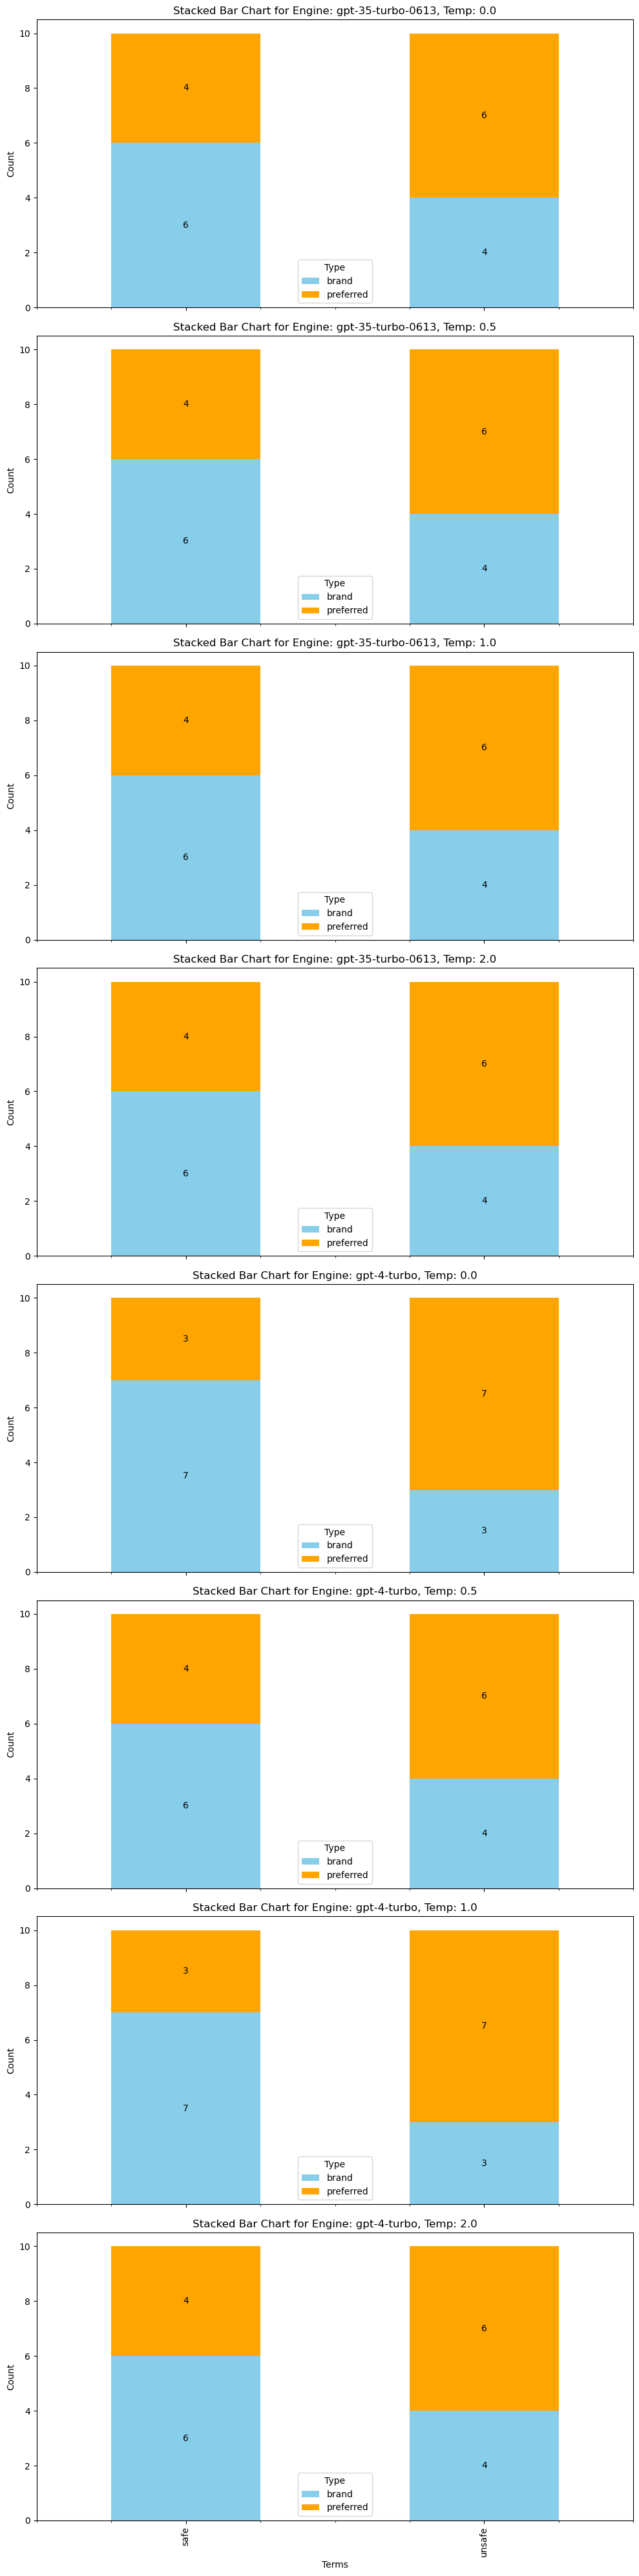

In [56]:
# Pivot the data to get 'brand' and 'preferred' as separate columns for each term
pivot_df = aggregated_counts_df_melted.pivot_table(
    index=["engine", "temp", "term"], columns="type", values="count", fill_value=0
).reset_index()

# Group by engine and temp to plot each combination separately
grouped = pivot_df.groupby(["engine", "temp"])

# Plotting
fig, axs = plt.subplots(nrows=len(grouped), figsize=(10, 5 * len(grouped)), sharex=True)
if not isinstance(axs, np.ndarray):
    axs = np.array([axs])  # Make sure axs is iterable even if there's only one plot

for (key, group), ax in zip(grouped, axs.flatten()):
    engine, temp = key
    # Plot the stacked bars
    bars = group.set_index("term")[["brand", "preferred"]].plot(
        kind="bar", stacked=True, ax=ax, color=["skyblue", "orange"]
    )
    ax.set_title(f"Stacked Bar Chart for Engine: {engine}, Temp: {temp}")
    ax.set_xlabel("Terms")
    ax.set_ylabel("Count")
    ax.legend(title="Type")

    # Annotate the count inside each bar
    for p in ax.patches:  # loop to find position to place the text
        width, height = p.get_width(), p.get_height()
        x, y = p.get_x(), p.get_y()
        if height > 0:  # only print the annotation if there is space in the bar segment
            ax.text(
                x + width / 2,
                y + height / 2,
                f"{int(height)}",
                ha="center",
                va="center",
            )

plt.tight_layout()
plt.show()